In [1]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install num2words

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import nltk
import numpy as np
import pandas as pd
import gzip
import torch
import requests
import json
from nltk.corpus import brown
from torch.utils.data import Dataset, DataLoader
import random
import io
from io import open
import unicodedata
import string
import re
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
import json
from collections import Counter
import torch.nn.functional as F
import requests
import pandas as pd
import nltk
from nltk.probability import FreqDist
import string
from nltk.stem import SnowballStemmer
import num2words
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import num2words
import time

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda')

In [6]:
# Download SQuAD2 dataset
url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json"
response = requests.get(url)

#Save the dataset to a file
dataset_file = "squad2.json"
with open(dataset_file, 'wb') as f:
   f.write(response.content)

In [7]:
#download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
#We will use this function on each file in the dataset - test and train
#only the filename is required as the previous function returns the specified file to the same location

def extract_squad_data(file_name):
    with open(file_name, 'r', encoding='utf-8') as f:
        file_name = json.load(f)

    paragraphs = []
    for article in file_name['data']:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                question = qa['question']
                answers = [answer['text'] for answer in qa['answers']]
                for answer in answers:
                    paragraphs.append((question, answer))

    df = pd.DataFrame(paragraphs, columns=['Question', 'Answer'])
    return df

In [9]:
#convert .json files to dataframes
squad_df = extract_squad_data("squad2.json") 

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_word_histogram_side_by_side(dataframe, question_column, answer_column, title):
    # Combine all the words from the question_column into a single string
    all_question_words = ' '.join(dataframe[question_column].values.tolist())

    # Split the string into individual words for the question_column
    question_word_list = all_question_words.split()

    # Combine all the words from the answer_column into a single string
    all_answer_words = ' '.join(dataframe[answer_column].values.tolist())

    # Split the string into individual words for the answer_column
    answer_word_list = all_answer_words.split()

    # Count the frequency of each word for the question_column
    question_word_counts = {}
    for word in question_word_list:
        question_word_counts[word] = question_word_counts.get(word, 0) + 1

    # Count the frequency of each word for the answer_column
    answer_word_counts = {}
    for word in answer_word_list:
        answer_word_counts[word] = answer_word_counts.get(word, 0) + 1

    # Calculate the frequency buckets for the question_column
    question_bucket_counts = [0] * 10
    for count in question_word_counts.values():
        if count < 5:
            question_bucket_counts[0] += 1
        elif count < 10:
            question_bucket_counts[1] += 1
        elif count < 15:
            question_bucket_counts[2] += 1
        elif count < 20:
            question_bucket_counts[3] += 1
        elif count < 25:
            question_bucket_counts[4] += 1
        elif count < 30:
            question_bucket_counts[5] += 1
        elif count < 35:
            question_bucket_counts[6] += 1
        elif count < 40:
            question_bucket_counts[7] += 1
        elif count < 45:
            question_bucket_counts[8] += 1
        else:
            question_bucket_counts[9] += 1

    # Calculate the frequency buckets for the answer_column
    answer_bucket_counts = [0] * 10
    for count in answer_word_counts.values():
        if count < 5:
            answer_bucket_counts[0] += 1
        elif count < 10:
            answer_bucket_counts[1] += 1
        elif count < 15:
            answer_bucket_counts[2] += 1
        elif count < 20:
            answer_bucket_counts[3] += 1
        elif count < 25:
            answer_bucket_counts[4] += 1
        elif count < 30:
            answer_bucket_counts[5] += 1
        elif count < 35:
            answer_bucket_counts[6] += 1
        elif count < 40:
            answer_bucket_counts[7] += 1
        elif count < 45:
            answer_bucket_counts[8] += 1
        else:
            answer_bucket_counts[9] += 1

    # Calculate the total word count (Question + Answer)
    total_word_list = question_word_list + answer_word_list
    total_word_count = len(total_word_list)

    # Set the width of the bars
    bar_width = 0.35

    # Set the x locations of the bars
    r1 = np.arange(len(question_bucket_counts))
    r2 = [x + bar_width for x in r1]

    # Plot the histogram side by side
    plt.bar(r1, question_bucket_counts, color='b', width=bar_width, label=f'{question_column}')
    plt.bar(r2, answer_bucket_counts, color='orange', width=bar_width, label=f'{answer_column}')

    # Add a separate box/call out for total word count
    plt.text(len(question_bucket_counts) / 2, max(max(question_bucket_counts), max(answer_bucket_counts)),
             f'Total Words: {total_word_count}', ha='center', va='center', bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round'))

    # Add labels, title, and legend
    plt.xlabel('Frequency Range')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks([r + bar_width/2 for r in range(len(question_bucket_counts))], ['0-4', '5-9', '10-14', '15-19', '20-24',
                                                                        '25-29', '30-34', '35-39', '40-44', '45+'])
    plt.legend()

    # Show the plot
    plt.show()




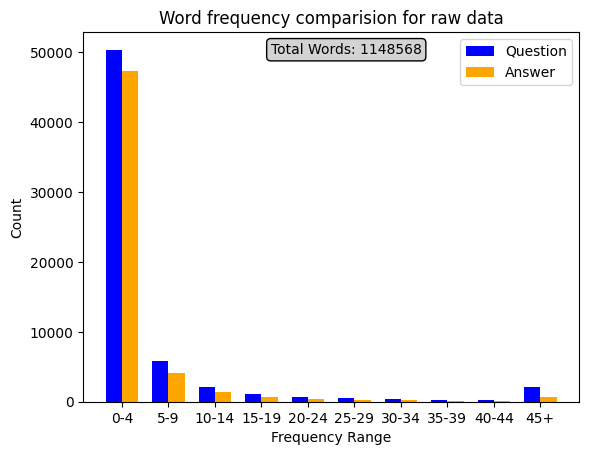

In [11]:
plot_word_histogram_side_by_side(squad_df, 'Question', 'Answer', 'Word frequency comparision for raw data')

In [12]:
#This Histogram shows the vast majority of the words appearly very infreqently. 
# This may negantivitly affect performance as such frequnctly appearing words may have little informational value and act as noise 
# Hence data the data cleaning below (ext cleaning, tokenising, removing stopwords, removing rare words (<2))

In [13]:
#sample of src/answer pairs for raw datat
print("Training Vocab trg Raw")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(squad_df['Question'].head(5))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Testing Vocab src Raw")
print(squad_df['Answer'].head(5))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

Training Vocab trg Raw
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0             When did Beyonce start becoming popular?
1    What areas did Beyonce compete in when she was...
2    When did Beyonce leave Destiny's Child and bec...
3        In what city and state did Beyonce  grow up? 
4           In which decade did Beyonce become famous?
Name: Question, dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Testing Vocab src Raw
0      in the late 1990s
1    singing and dancing
2                   2003
3         Houston, Texas
4             late 1990s
Name: Answer, dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [14]:
"""#pre-cleaned questions and trg to list
raw_src = train_df['Question'].tolist()
raw_answers = train_df['Answer'].tolist()"""

"#pre-cleaned questions and trg to list\nraw_src = train_df['Question'].tolist()\nraw_answers = train_df['Answer'].tolist()"

In [15]:
#Text cleaning, tokenising, removing stopwords, removing rare words (<2)
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import string
from nltk.stem import SnowballStemmer
from num2words import num2words

stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))  # NLTK's list of English stop words

def clean_text(df, min_freq=2):  # min_freq: minimum frequency to keep a token
    cleaned_df = df.copy()
    all_tokens = []  # List to store all tokens for frequency calculation
    
    for column in cleaned_df:
        cleaned_df[column] = cleaned_df[column].apply(lambda sentence: process_sentence(sentence, all_tokens))
        
    # Create frequency distribution of tokens
    freq_dist = FreqDist(all_tokens)
    
    # Identify rare tokens
    rare_tokens = {token for token, freq in freq_dist.items() if freq < min_freq}
    
    # Remove rare tokens from the dataframe
    for column in cleaned_df:
        cleaned_df[column] = cleaned_df[column].apply(lambda sentence: ' '.join(token for token in sentence.split() if token not in rare_tokens))
        
    return cleaned_df

def process_sentence(sentence, all_tokens):
    sentence = ''.join([s.lower() for s in sentence if s not in string.punctuation])
    sentence = ' '.join(stemmer.stem(w) for w in sentence.split())
    
    # Convert numbers to words
    sentence = ' '.join(convert_num_to_words(w) for w in sentence.split())
    
    # Remove stop words
    sentence = ' '.join(w for w in sentence.split() if w not in stop_words)
    
    tokens = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(sentence)
    
    # Add tokens to the all_tokens list
    all_tokens.extend(tokens)
    
    return ' '.join(tokens)

def convert_num_to_words(s):
    try:
        # Remove comma from numbers
        s = s.replace(',', '')
        # If the string represents a fraction, convert both parts separately
        if '/' in s:
            numerator, denominator = s.split('/')
            return num2words(int(numerator)) + ' over ' + num2words(int(denominator))
        # Otherwise, try converting the string to an integer or a float
        try:
            return num2words(int(s))
        except ValueError:
            return num2words(float(s))
    except:
        # If any of the above attempts throw an exception, the string is not a number
        return s


In [16]:
#clean raw data files
squad_clean_df = clean_text(squad_df)


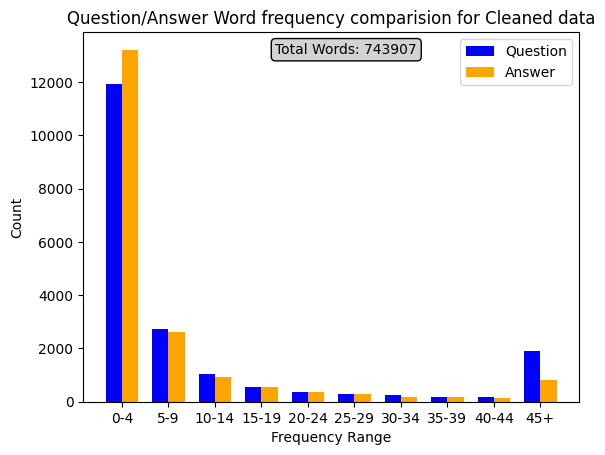

In [17]:
#Histrograme of word fequency for cleaned data
plot_word_histogram_side_by_side(squad_clean_df, 'Question', 'Answer', 'Question/Answer Word frequency comparision for Cleaned data')

In [18]:
#A significant number of words have been removed, especally those in the 0-4 class. 
# This is to be expected since we removed all words with a frequency of less than 2 and all stop words (that tend to have a frequency of 4 or less)

In [19]:
print("Training Vocab Answers Cleaned")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(squad_clean_df['Question'].head(5))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("Testing Vocab src Cleaned")
print(squad_clean_df['Answer'].head(5))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

Training Vocab Answers Cleaned
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0                     beyonc start becom popular
1                        area beyonc compet grow
2    beyonc leav destini child becom solo singer
3                         citi state beyonc grow
4                      decad beyonc becom famous
Name: Question, dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Testing Vocab src Cleaned
0            late 1990s
1             sing danc
2    two thousand three
3          houston texa
4            late 1990s
Name: Answer, dtype: object
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [20]:
#Vocab class that builds vocab, checks for unquie words, and assigns to an index value
class Vocab:
    def __init__(self):
        self.word2index = {}
        self.index2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.word2count = {}
        self.n_words = 4  # Count <PAD>, <SOS>, <EOS>, <UNK>

    def build_vocab(self, sentences):
        unique_words = set()
        for sentence in sentences:
            for word in self.tokenize(sentence):
                unique_words.add(word)

        for word in unique_words:
            self.add_word(word)

    def tokenize(self, sentence):
        return sentence.strip().split()

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.word2count[word] = 1
            self.n_words += 1
        else:
            self.word2count[word] += 1


In [21]:
questions = squad_clean_df['Question']
answers = squad_clean_df['Answer']

In [22]:
#cleaned question/answer pairs to Vocab
question_vocab = Vocab()
answer_vocab = Vocab()


question_vocab.build_vocab(questions)
answer_vocab.build_vocab(answers)

question_vocab.add_word('<UNK>')
answer_vocab.add_word('<UNK>')

# Define and build your vocabularies


In [23]:
print(question_vocab.n_words)

19385


In [24]:
#counting vocab sizes
print("Training Set, question Vocab size in unique tokens")
question_vocab_size = len(question_vocab.word2count)
print(question_vocab_size)

print("#############################################")

print("Training Set, Answer Vocab size in unique tokens")
answer_vocab_size = len(answer_vocab.word2count)
print(answer_vocab_size)

Training Set, question Vocab size in unique tokens
19381
#############################################
Training Set, Answer Vocab size in unique tokens
19261


In [28]:
def pad_or_cut(df, column_names, length):
    pad_symbol = "<PAD>"
    
    for column_name in column_names:
        df[column_name] = df[column_name].apply(lambda x: (x.split()[:length] + [pad_symbol]*length)[:length])
        df[column_name] = df[column_name].apply(lambda x: ' '.join(x))
    return df


In [29]:

padded_df = pad_or_cut(squad_clean_df, ['Question', 'Answer'], 10)

In [30]:
def words_to_indices(df, question_vocab, answer_vocab):
    df['Question'] = df['Question'].apply(lambda sentence: [question_vocab.word2index[word] if word in question_vocab.word2index else question_vocab.word2index['<UNK>'] for word in sentence.split()])
    df['Answer'] = df['Answer'].apply(lambda sentence: [answer_vocab.word2index[word] if word in answer_vocab.word2index else answer_vocab.word2index['<UNK>'] for word in sentence.split()])
    return df

In [31]:
idx_df = words_to_indices(padded_df, question_vocab, answer_vocab) # could have used nn.padding & nn.embedding

In [32]:
idx_df_save = idx_df

In [33]:
idx_df

,Question,Answer
0,"[14580, 1437, 11289, 2141, 19384, 19384, 19384...","[12594, 10733, 19264, 19264, 19264, 19264, 192..."
1,"[12103, 14580, 17876, 2184, 19384, 19384, 1938...","[1232, 4866, 19264, 19264, 19264, 19264, 19264..."
2,"[14580, 7233, 8571, 12121, 11289, 17718, 11888...","[4063, 15188, 6087, 19264, 19264, 19264, 19264..."
3,"[7333, 14343, 14580, 2184, 19384, 19384, 19384...","[1865, 6513, 19264, 19264, 19264, 19264, 19264..."
4,"[110, 14580, 11289, 9720, 19384, 19384, 19384,...","[12594, 10733, 19264, 19264, 19264, 19264, 192..."
...,...,...
86816,"[764, 14343, 8227, 4662, 17956, 11017, 2679, 1...","[13256, 19264, 19264, 19264, 19264, 19264, 192..."
86817,"[8794, 8636, 12797, 19384, 19384, 19384, 19384...","[16814, 19264, 19264, 19264, 19264, 19264, 192..."
86818,"[3171, 7333, 7962, 8227, 2679, 19384, 19384, 1...","[19264, 19264, 19264, 19264, 19264, 19264, 192..."
86819,"[12519, 8227, 14412, 8376, 11017, 2679, 19384,...","[14710, 15188, 15352, 4885, 8691, 12290, 19264..."


In [34]:
idx_df.head(20)



,Question,Answer
0,"[14580, 1437, 11289, 2141, 19384, 19384, 19384...","[12594, 10733, 19264, 19264, 19264, 19264, 192..."
1,"[12103, 14580, 17876, 2184, 19384, 19384, 1938...","[1232, 4866, 19264, 19264, 19264, 19264, 19264..."
2,"[14580, 7233, 8571, 12121, 11289, 17718, 11888...","[4063, 15188, 6087, 19264, 19264, 19264, 19264..."
3,"[7333, 14343, 14580, 2184, 19384, 19384, 19384...","[1865, 6513, 19264, 19264, 19264, 19264, 19264..."
4,"[110, 14580, 11289, 9720, 19384, 19384, 19384,...","[12594, 10733, 19264, 19264, 19264, 19264, 192..."
5,"[1268, 7277, 7952, 11888, 19384, 19384, 19384,...","[8481, 12082, 19264, 19264, 19264, 19264, 1926..."
6,"[4895, 5285, 14547, 12797, 11178, 19384, 19384...","[18097, 14151, 19264, 19264, 19264, 19264, 192..."
7,"[14479, 8571, 12121, 7277, 19384, 19384, 19384...","[9399, 19264, 19264, 19264, 19264, 19264, 1926..."
8,"[4075, 6033, 6427, 19384, 19384, 19384, 19384,...","[12594, 10733, 19264, 19264, 19264, 19264, 192..."
9,"[16053, 4075, 8571, 12121, 19384, 19384, 19384...","[7860, 11844, 19264, 19264, 19264, 19264, 1926..."


In [35]:
import sklearn

In [36]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

class QnADataset(Dataset):
    def __init__(self, src, trg):
        self.src = src
        self.trg = trg

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        return self.src[idx], self.trg[idx]




In [37]:
# Define the proportion of the data you want in your validation and test sets
val_size = 0.1
test_size = 0.1

# Ensure that the validation and test set proportions sum to less than 1
assert val_size + test_size < 1

# Separate your DataFrame into two separate sets of sequences.
src = idx_df['Question'].tolist()
trg = idx_df['Answer'].tolist()

src_vocab = question_vocab
trg_vocab = answer_vocab

src_word2index = src_vocab.word2index
trg_word2index = trg_vocab.word2index


# Convert words in your sequences to their corresponding indices
src = [[src_vocab.word2index[word] if word in src_vocab.word2index else src_vocab.word2index['<UNK>'] for word in sequence] for sequence in src]
trg = [[trg_vocab.word2index[word] if word in trg_vocab.word2index else trg_vocab.word2index['<UNK>'] for word in sequence] for sequence in trg]

# Convert your sequences to PyTorch tensors
src = [torch.tensor(item) for item in src]
trg = [torch.tensor(item) for item in trg]

# First split into train and temp sets
src_train, src_temp, trg_train, trg_temp = train_test_split(
    src, trg, test_size=(val_size+test_size), random_state=42)

# Split the temp set into validation and test sets
src_val, src_test, trg_val, trg_test = train_test_split(
    src_temp, trg_temp, test_size=test_size/(val_size+test_size), random_state=42)

# Create datasets
train_dataset = QnADataset(src_train, trg_train)
val_dataset = QnADataset(src_val, trg_val)
test_dataset = QnADataset(src_test, trg_test)

# Create DataLoaders for training, validation, and test sets
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)


In [39]:
print(len(src_word2index))

19381


In [40]:
import torch
import torch.nn as nn

class Encoder(nn.Module):

    def __init__(self, input_size, hidden_size, embedding_size, pretrained_embeddings=None):

        super(Encoder, self).__init__()

        self.embedding_size = embedding_size

        # self.embedding provides a vector representation of the inputs to our model
        self.embedding = nn.Embedding(input_size, embedding_size)

        # Load the pretrained embeddings, if available
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))

        self.lstm = nn.LSTM(embedding_size, hidden_size)

    def forward(self, i):

        embedded = self.embedding(i)

        o, (h, c) = self.lstm(embedded)

        return o, h, c


class Decoder(nn.Module):

    def __init__(self, hidden_size, output_size, embedding_size, pretrained_embeddings=None):

        super(Decoder, self).__init__()

        self.embedding_size = embedding_size

        # self.embedding provides a vector representation of the target to our model
        self.embedding = nn.Embedding(output_size, embedding_size)

        # Load the pretrained embeddings, if available
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))

        self.lstm = nn.LSTM(embedding_size, hidden_size)

        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, i, h):

        embedded = self.embedding(i)

        o, h = self.lstm(embedded, h)

        output = self.output(o)

        return output, h


class Seq2Seq(nn.Module):
    def __init__(self, encoder_input_size, encoder_hidden_size, decoder_hidden_size, decoder_output_size, embedding_size, pretrained_embeddings=None):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(encoder_input_size, encoder_hidden_size, embedding_size, pretrained_embeddings)
        self.decoder = Decoder(decoder_hidden_size, decoder_output_size, embedding_size, pretrained_embeddings)

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output.out_features

        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(src.device)

        # Encode the input sequence
        o, h, c = self.encoder(src)

        # Initialize the decoder hidden state
        decoder_hidden = (h.repeat(self.decoder.lstm.num_layers, 1, 1),
                          c.repeat(self.decoder.lstm.num_layers, 1, 1))

        # Set the input to the first token of the target sequence
        input_token = trg[0, :]

        for t in range(1, max_len):
            output, decoder_hidden = self.decoder(input_token.unsqueeze(0), decoder_hidden)
            outputs[t] = output.squeeze(0)

            # Decide whether to use teacher forcing or not
            teacher_force = torch.rand(1) < teacher_forcing_ratio

            # Set the input token to either the target token or the predicted token
            input_token = trg[t] if teacher_force else output.argmax(dim=2).squeeze(0)

        return outputs


In [41]:
print()

In [42]:
# Initialize the model
encoder_input_size = len(src_word2index)
encoder_hidden_size = 256
decoder_hidden_size = 256
decoder_output_size = len(trg_word2index)
embedding_size = 100
#pretrained_embeddings=None
model = Seq2Seq(encoder_input_size, encoder_hidden_size, decoder_hidden_size, decoder_output_size, embedding_size)

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [45]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(19381, 100)
    (lstm): LSTM(100, 256)
  )
  (decoder): Decoder(
    (embedding): Embedding(19261, 100)
    (lstm): LSTM(100, 256)
    (output): Linear(in_features=256, out_features=19261, bias=True)
  )
)

In [46]:

criterion = nn.CrossEntropyLoss()


optimizer = torch.optim.Adam(model.parameters())

In [47]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(19381, 100)
    (lstm): LSTM(100, 256)
  )
  (decoder): Decoder(
    (embedding): Embedding(19261, 100)
    (lstm): LSTM(100, 256)
    (output): Linear(in_features=256, out_features=19261, bias=True)
  )
)

In [48]:
# Define the training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0

    for src, trg in train_loader:
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()

        output = model(src, trg)

        # The output dimensions are [trg len, batch size, output dim] but the loss function expects
        # the inputs to be [batch size, output dim] and the targets to be [batch size]
        output = output[1:].reshape(-1, output.shape[-1])
        trg = trg[1:].reshape(-1)

        loss = criterion(output, trg)

        loss.backward()

        optimizer.step()

        total_loss += loss.item()



    return total_loss / len(train_loader)

In [49]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for src, trg in test_loader:
            src, trg = src.to(device), trg.to(device)

            output = model(src, trg, teacher_forcing_ratio=0.0)  # Disable teacher forcing during evaluation

            # The output dimensions are [trg len, batch size, output dim] but the loss function expects
            # the inputs to be [batch size, output dim] and the targets to be [batch size]
            output = output[1:].reshape(-1, output.shape[-1])
            trg = trg[1:].reshape(-1)

            loss = criterion(output, trg)

            total_loss += loss.item()

    return total_loss / len(test_loader)

In [50]:
#train with time
# Train the model

train_losses = []
test_losses = []


num_epochs = 2
for epoch in range(num_epochs):
    start_time = time.time()  # Start time for the epoch

    train_loss = train(model, train_dataloader, criterion, optimizer, device)
    test_loss = evaluate(model, test_dataloader, criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    end_time = time.time()  # End time for the epoch
    epoch_time = end_time - start_time  # Time taken for the epoch

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Time: {epoch_time:.2f} seconds')

../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [50,0,0], thread: [64,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [50,0,0], thread: [65,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [50,0,0], thread: [66,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [50,0,0], thread: [67,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [50,0,0], thread: [68,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [50,0,0], thread: [69,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [50,0,0], t

RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR

In [ ]:
"""# Training function
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)"""


In [ ]:
"""# Hyperparameters
N_EPOCHS = 10
CLIP = 1

# Define an optimizer and a loss function (criterion)
optimizer = optim.Adam(model.parameters())
TRG_PAD_IDX = trg_vocab.word2index['<PAD>']
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

# Training loop
for epoch in range(N_EPOCHS):
    train_loss = train(model, train_dataloader, optimizer, criterion, CLIP)
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')"""